# Using the lichess api to get data insights on an individual user's games

This is an example of how to use Lichess API data to find trends within your own games (or someone else's). There's a lot more that can be done, but this may be a useful primer. I'm using a Python wrapper called **berserk**, which is recommended on the Lichess API page here: https://lichess.org/api. 

You can get a token here https://lichess.org/account/oauth/token

Wrapper documentation: https://github.com/rhgrant10/berserk

In [1]:
# Importing lichess python wrapper, some other modules, and establishing token and player name

import pandas as pd
import numpy as np
import time
import berserk
from config import TOKEN

# Store in config
TOKEN = TOKEN
PLAYER = 'classy_kylieee'

In [2]:
# For data visualization later

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette("hls")
sns.set()
%matplotlib inline

In [3]:
# Starting session with token

session = berserk.TokenSession(TOKEN)
client = berserk.Client(session=session)

In [4]:
# Getting list of games based on player

client.games.export_by_player(PLAYER)
games = list(_)

<generator object Games.export_by_player at 0x7fb75d75aa20>

In [5]:
# Creating a dataframe of the games
df = pd.DataFrame(games)

In [6]:
# Getting a list of game ids to get more data on each with export game function
list_of_games = list(df['id'])

**This next step is not necessary unless you want to work with opening and analysis data. Everything else you need is included with the export_by_player function**

Here we will loop through the game ids, calling the api to get data on each and store in a list to be converted 
into a dataframe after cleaning it up.

Sleeping for one second or we will hit a rate limit. If you try it in a list comprehension without sleeping, you
will most likely get an error. This will take a while depending on how many games you're getting.

In [7]:
for_games_df = []
for i in list_of_games:
    temp = client.games.export(i)
    for_games_df.append(temp)
    time.sleep(1)

In [8]:
# Cleaning up data before creating a dataframe, establishing new columns for ease of use

for i in for_games_df:
    
    # Dealing with the games against stockfish which contain different data
    
    if 'aiLevel'in i['players']['white'].keys():
        i['white_player'] = 'Stockfish'
        i['white_player_rating'] = 'Stockfish'
    else:
        i['white_player'] = i['players']['white']['user']['name']
        i['white_player_rating'] = i['players']['white']['rating']
        
    if 'aiLevel'in i['players']['black'].keys():
        i['black_player'] = 'Stockfish'
        i['black_player_rating'] = 'Stockfish'
    else:
        i['black_player'] = i['players']['black']['user']['name']
        i['black_player_rating'] = i['players']['black']['rating']
        
        
    # Sometimes opening data is in a dictionary with a 'name' and sometimes it's already just a string    
    
    if 'opening' in i.keys():
        if type(i['opening']) is dict:
            i['opening'] = i['opening']['name']
        else:
            i['opening'] = i['opening']
            
    # If there is no opening data, it's because it is a game played from particular position
    
    else:
        i['opening'] = 'From Position'
        

In [9]:
# Creating a new dataframe with the new column data and replacing NaN values with 0 for ease of use

games_df = pd.DataFrame(for_games_df)
games_df.fillna(0, inplace=True)

In [10]:
# Notice below that the games_df has two additional columns, analysis and opening. We'll be working with that
# dataframe.

df.columns

Index(['id', 'rated', 'variant', 'speed', 'perf', 'createdAt', 'lastMoveAt',
       'status', 'players', 'winner', 'moves', 'clock'],
      dtype='object')

In [11]:
games_df.columns

Index(['id', 'rated', 'variant', 'speed', 'perf', 'createdAt', 'lastMoveAt',
       'status', 'players', 'winner', 'opening', 'moves', 'clock',
       'white_player', 'white_player_rating', 'black_player',
       'black_player_rating', 'analysis'],
      dtype='object')

In [12]:
# Creating conditions to get a clear result for the player's data, if the 'winner' was NaN (which we converted to 0),
# that means the result was a draw

conditions = [
    (games_df['winner'] == 0),
    (games_df['winner'] == 'white') & (games_df['white_player'] == PLAYER),
    (games_df['winner'] == 'black') & (games_df['black_player'] == PLAYER),
    (games_df['winner'] == 'white') & (games_df['white_player'] != PLAYER),
    (games_df['winner'] == 'black') & (games_df['black_player'] != PLAYER)
]

values = ['Draw', 'Win', 'Win', 'Loss', 'Loss']

games_df['result'] = np.select(conditions, values)

In [13]:
# Get value_counts as percentage for results
# This is a total win/loss/draw percentage

games_df['result'].value_counts(normalize=True)

Win     0.478261
Loss    0.468227
Draw    0.053512
Name: result, dtype: float64

In [14]:
# Parse clock data for initial time and increment

games_df['initial'] = games_df['clock'].apply(lambda x: x['initial'])
games_df['increment'] = games_df['clock'].apply(lambda x: x['increment'])

In [15]:
# Establish the white and black player names in separate columns for ease of use

games_df['white_player'] = games_df.players.apply(lambda x: x['white']['user']['name'])
games_df['black_player'] = games_df.players.apply(lambda x: x['black']['user']['name'])

In [16]:
# If you want to get dataframes with data only from specific time controls, you can do it like so
# Initial is the number of minutes (in seconds), e.g. 300 is five minutes

five_plus_three = games_df[(games_df['initial'] == 300) & (games_df['increment'] == 3)]

# Creating some dataframes for each major lichess time control in case we want to break it down that way
# one_plus_zero = games_df[(games_df['initial'] == 60) & (games_df['increment'] == 0)]
# two_plus_one = games_df[(games_df['initial'] == 120) & (games_df['increment'] == 1)]
# three_plus_zero = games_df[(games_df['initial'] == 180) & (games_df['increment'] == 0)]
# three_plus_two = games_df[(games_df['initial'] == 180) & (games_df['increment'] == 2)]
# five_plus_zero = games_df[(games_df['initial'] == 300) & (games_df['increment'] == 3)]
# five_plus_three = games_df[(games_df['initial'] == 300) & (games_df['increment'] == 0)]
# ten_plus_zero = games_df[(games_df['initial'] == 600) & (games_df['increment'] == 0)]
# ten_plus_five = games_df[(games_df['initial'] == 600) & (games_df['increment'] == 5)]
# fifteen_plus_ten = games_df[(games_df['initial'] == 900) & (games_df['increment'] == 10)]
# thirty_plus_zero = games_df[(games_df['initial'] == 1800) & (games_df['increment'] == 0)]
# thirty_plus_twenty = games_df[(games_df['initial'] == 1800) & (games_df['increment'] == 20)]

### Below is how we can work a bit with opening data.

You will need to have used the export function as we did in Cell 7 to have this column available.

Here we get all available openings and create a dataframe for each with the name being the opening for future graphing purposes

Then we groupby the opening that we established earlier, and get a value count on the result. We unstack
and fill the empty values with zero and restack to make sure we keep records with 0 in the data, then
we just turn the groupby into a dataframe and organize the columns.

Setting normalize to true will give you these in percentages.

In [17]:
opening_breakdown = games_df.groupby('opening')['result'].value_counts(normalize=False).unstack(fill_value=0).stack().to_frame().reset_index().rename(columns={0:'COUNT'})

# Create a separate dataframe for each opening value count and store in a list

list_of_opening_dfs = []

opening_list = opening_breakdown['opening'].unique()

for opening in opening_list:
    temp_df = opening_breakdown[opening_breakdown['opening'] == opening]
    temp_df.name = opening
    list_of_opening_dfs.append(temp_df)

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Caro-Kann Defense')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Caro-Kann Defense: Advance Variation')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Caro-Kann Defense: Exchange Variation')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Caro-Kann Defense: Main Line')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Caro-Kann Defense: Tartakower Variation')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Giuoco Piano')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Italian Game: Anti-Fried Liver Defense')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Italian Game: Classical Variation, Giuoco Pianissimo')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Pirc Defense')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, "Queen's Pawn Game: Steinitz Countergambit")

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Sicilian Defense: Alapin Variation')

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Slav Defense')

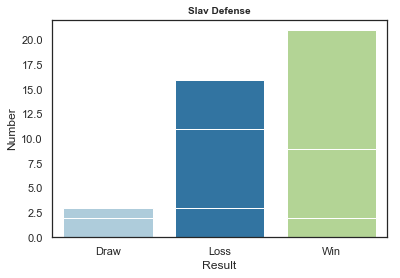

In [18]:
# Producing graphs per opening if there is a decent amount of data to work with (aka >4 games)

for opening in list_of_opening_dfs:
    if opening.COUNT.sum()>4:
        
        # Look at matplotlib and seaborn documentation to customize
        sns.set_style("white")
        ax = sns.barplot(palette=sns.color_palette('Paired'), data=opening, x=opening['result'], y='COUNT')
        ax.set(xlabel='Result', ylabel='Number')
        ax.set_title(opening.name, fontdict = { 'fontsize': 10, 'fontweight':'bold'})
        ax = ax.figure
        # Here you can save the graphs to a folder on your local machine if you so choose
        # ax.savefig('/some path/'+opening.name+'.png')
    else:
        continue

## We can break things down by time control, as well.

As stated above, you can instead use a more specific breakdown by creating dataframes for each initial/increment pairing

In [19]:
tc_df_list = []

tc = games_df.groupby('perf').result.value_counts().unstack(fill_value=0).stack().to_frame().rename(columns={'result':'COUNT'}).reset_index()
blitz = tc[tc['perf']=='blitz'].rename(columns={0:'Count'})
blitz.name = 'Blitz'
bullet = tc[tc['perf']=='bullet'].rename(columns={0:'Count'})
bullet.name = 'Bullet'
classical = tc[tc['perf']=='classical'].rename(columns={0:'Count'})
classical.name = 'Classical'
rapid = tc[tc['perf']=='rapid'].rename(columns={0:'Count'})
rapid.name = 'Rapid'

tc_df_list.extend([blitz, bullet, classical, rapid])


[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Blitz')

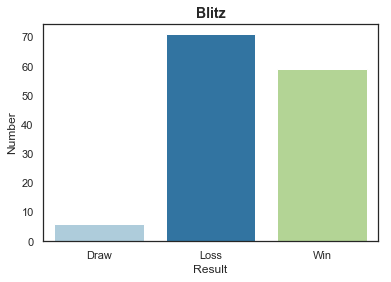

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Bullet')

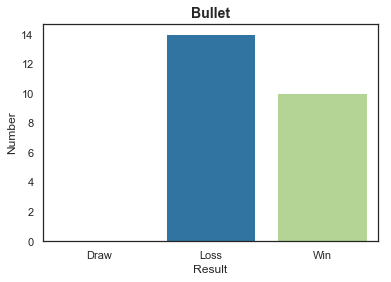

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Classical')

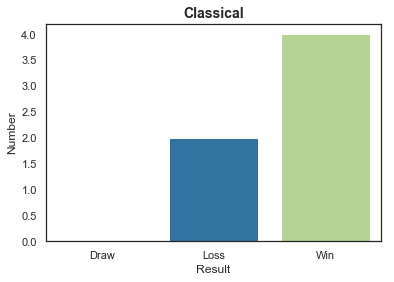

[Text(0, 0.5, 'Number'), Text(0.5, 0, 'Result')]

Text(0.5, 1.0, 'Rapid')

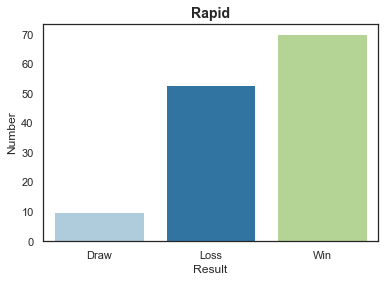

In [20]:
# Make some time control graphs

for df in tc_df_list:
    sns.set_style("white")
    ax = sns.barplot(palette=sns.color_palette('Paired'), data=df, x=df['result'], y='Count')
    ax.set(xlabel='Result', ylabel='Number')
    ax.set_title(df.name, fontdict = { 'fontsize': 14, 'fontweight':'bold'})
    ax = ax.figure
    plt.show()

### Below we break things down by the hour of day and the day of week

In can be fun to see at white time of day you play and win the most, as well as what day of the week. Maybe
you can establish your absolute best playing time.


In [21]:
# Get time data
games_df['datetime'] = pd.to_datetime(games_df.createdAt)

# Adjust for timezone. This is UTC minus four hours for EST
games_df['datetime'] = games_df['datetime'].apply(lambda x: x-np.timedelta64(4, 'h'))

games_df['hour'] = games_df['datetime'].apply(lambda x: x.hour)
games_df['day_of_week'] = games_df['datetime'].apply(lambda x: x.weekday())
games_df['day_of_week'] = games_df['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
games_df['month'] = games_df['datetime'].apply(lambda x: x.month)

In [22]:
## Doing stuff with hour data
hour_vc = games_df['hour'].value_counts().sort_index().to_frame().rename(columns={'hour':'COUNT'})

<Figure size 1152x432 with 0 Axes>

[Text(0, 0.5, 'Number of Games'), Text(0.5, 0, 'Hour of Day')]

Text(0.5, 1.0, 'Hourly Breakdown')

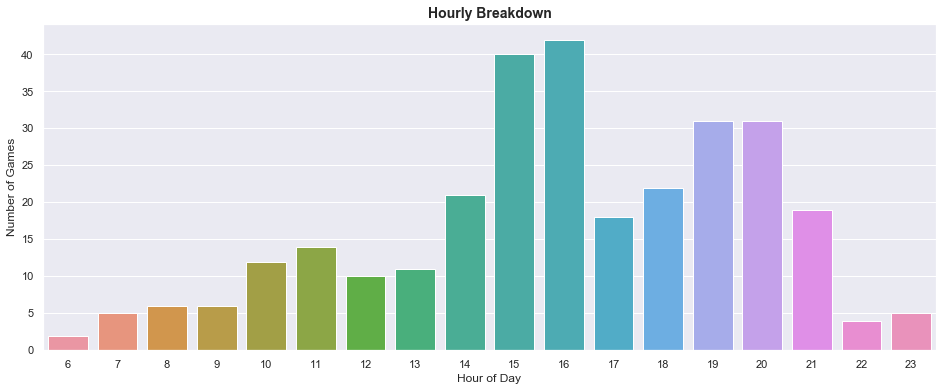

In [23]:
# Games played by hour of day
sns.set(style='darkgrid')
plt.figure(figsize=(16,6))
ax2 = sns.barplot(data=hour_vc, x=hour_vc.index, y='COUNT')
ax2.set(xlabel='Hour of Day', ylabel='Number of Games')
ax2.set_title('Hourly Breakdown', fontdict = { 'fontsize': 14, 'fontweight':'bold'})

In [24]:
# Get win percentage per hour
win_hour_vc = games_df[games_df['result'] == 'Win'].hour.value_counts().sort_index().to_frame().rename(columns={'hour':'COUNT'})
win_hour_perc = win_hour_vc/hour_vc

<Figure size 1152x432 with 0 Axes>

[Text(0, 0.5, 'Win %'), Text(0.5, 0, 'Hour of Day')]

Text(0.5, 1.0, 'Win Percentage by Hour of Day')

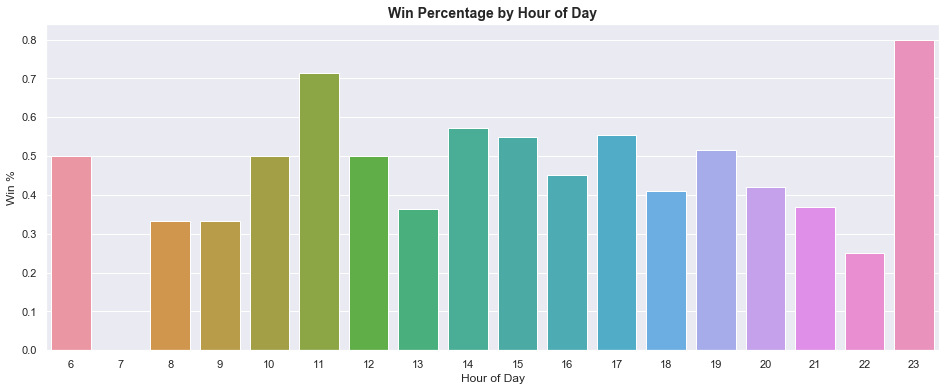

In [25]:
# Win percentage by hour of day plot, aka what time do you play your best?
sns.set(style='darkgrid')
plt.figure(figsize=(16,6))
ax2 = sns.barplot(data=win_hour_perc, x=hour_vc.index, y='COUNT')
ax2.set(xlabel='Hour of Day', ylabel='Win %')
ax2.set_title('Win Percentage by Hour of Day', fontdict = { 'fontsize': 14, 'fontweight':'bold'})

In [26]:
# Do stuff with day of week data
day_of_week_vc = games_df['day_of_week'].value_counts().to_frame().rename(columns={'day_of_week':'COUNT'})

In [27]:
# Make the days something human-readable in the right order
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_vc = day_of_week_vc.reindex(days)

<Figure size 1152x432 with 0 Axes>

Text(0, 0.5, 'Number of Games')

Text(0.5, 1.0, 'Games per Day of Week')

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

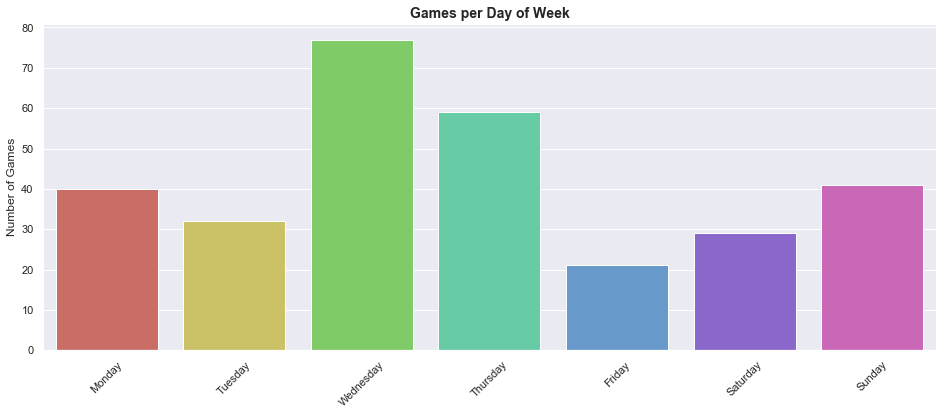

In [28]:
# Day of week plot
plt.figure(figsize=(16,6))
day_of_week_vc.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(data=day_of_week_vc, x=day_of_week_vc.index, y='COUNT', palette='hls')
ax.set_ylabel('Number of Games')
ax.set_title('Games per Day of Week', fontdict = { 'fontsize': 14, 'fontweight':'bold'})
ax.set_xticklabels(day_of_week_vc.index, rotation=45)

In [29]:
# Get win percentage per day of week

win_dow_vc = games_df[games_df['result'] == 'Win'].day_of_week.value_counts().to_frame().rename(columns={'day_of_week':'COUNT'})
win_dow_vc = win_dow_vc.reindex(days)
win_dow_perc = win_dow_vc/day_of_week_vc

<Figure size 1152x432 with 0 Axes>

[Text(0, 0.5, 'Win %'), Text(0.5, 0, 'Day of Week')]

Text(0.5, 1.0, 'Win Percentage by Day of Week')

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

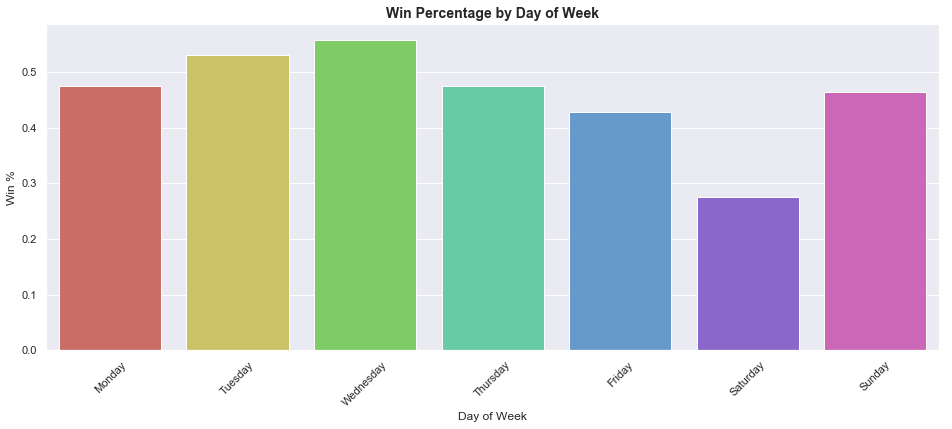

In [30]:
# Win Percentage by day of week. What day of week do you play your best?

sns.set(style='darkgrid')
plt.figure(figsize=(16,6))
ax2 = sns.barplot(data=win_dow_perc, x=win_dow_perc.index, y='COUNT', palette='hls')
ax2.set(xlabel='Day of Week', ylabel='Win %')
ax2.set_title('Win Percentage by Day of Week', fontdict = { 'fontsize': 14, 'fontweight':'bold'})
ax2.set_xticklabels(win_dow_perc.index, rotation=45)

## Conclusion

There is of course a lot more that can be done, but this can get you started. I will dig into the juicy analysis data and provide a notebook for that, as well. Enjoy!